(9, 75)
(90, 75)


In [2]:
import numpy as np
from common.util import im2col
import sys, os
sys.path.append(os.pardir)

In [8]:
x1 = np.random.rand(1, 3, 7, 7)  # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5,stride = 1, pad = 0)
print(col1.shape)  # (9, 75)

(9, 75)


In [9]:
x2 = np.random.rand(10, 3, 7, 7)  # 데이터 10개
col2 = im2col(x2, 5, 5)
print(col2.shape)  # (90, 75)


(90, 75)


In [14]:
x2 = np.random.rand(10, 3, 7, 7)  # 데이터 10개
col2 = im2col(x2, 5, 5,stride =1, pad = 1)
print(col2.shape)  # (90, 75)


(90, 75)


In [3]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

        # 입력 데이터와 필터를 2차원 배열로 전개하고 내적한다.
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T  # 필터 전개
        out = np.dot(col, col_W) + self.b

        # reshape에서 -1 : 원소 개수에 맞춰 적절하게 묶어줌.
        # transpose : 다차원 배열의 축 순서를 바꿔줌(N,H,W,C) -> (N,C,H,W)
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

In [4]:

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 최댓값 axis : 축의 방향, 0=열방향, 1=행방향
        out = np.max(col, axis=1)

        # 성형
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out



CNN 구현 전체 코드 및 실행 

In [8]:
import sys
import os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
from dataset.mnist import load_mnist
from common.trainer import Trainer


class SimpleConvNet:
    """
    다음과 같은 CNN을 구성한다.
    → Conv → ReLU → Pooling → Affine → ReLU → Affine → Softmax →
    전체 구현은 simple_convnet.py 참고
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5,
                             'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        
        # 초기화 인수로 주어진 하이퍼파라미터를 딕셔너리에서 꺼내고 출력 크기를 계산한다.
        filter_num = conv_param['filter_num'] 
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * # 풀링 계층의 출력 크기 계산
                               (conv_output_size/2))
        
        
#------------------------------------------------------------------------------------------

        

        # 1층의 합성곱 계층과 2, 3층의 완전연결 계층의 가중치와 편향 생성
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        
#-------------------------------------------------------------------------------------------   
    
    
        # CNN을 구성하는 계층을 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

        
# --------이전 수업주차에서 발표했던 내용.--------        
        
    def predict(self, x):
        """추론을 수행"""
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        """손실함수 값 계산"""
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        """오차역전파법으로 기울기를 구함"""
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

# 본 신경망으로 실제 MNIST 데이터셋을 학습하는 코드는 train_convnet.py 참고




In [9]:

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 10

network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

pred= np.expand_dims(x_test[0], axis =0)
pred = network.predict(pred)
print(pred)
print(np.argmax(pred))

"""
=============== Final Test Accuracy ===============
test acc:0.959

전체로 학습했을 경우 약 98%까지 가능
"""

train loss:2.299183017419629
=== epoch:1, train acc:0.2, test acc:0.18 ===
train loss:2.2948829112850238
train loss:2.289975877933789
train loss:2.2857038591013468
train loss:2.276006664744325
train loss:2.259622244872999
train loss:2.247924498348728
train loss:2.232139444768667
train loss:2.1945323744700205
train loss:2.169498205522848
train loss:2.1421194157498897
train loss:2.0668302809708163
train loss:2.0317561013534826
train loss:1.9604189798230192
train loss:1.9609938333999686
train loss:1.900716757225844
train loss:1.7474502414172748
train loss:1.768815622988031
train loss:1.6267020244085522
train loss:1.625198504347529
train loss:1.5170138918118192
train loss:1.5648153448998905
train loss:1.3876271932305904
train loss:1.310168702775476
train loss:1.2974814710106362
train loss:1.1398656163426493
train loss:1.1845033316875517
train loss:0.9496771924645848
train loss:0.8958167001353563
train loss:0.9509507509405968
train loss:0.8689258059700574
train loss:0.9847312037788134
train

train loss:0.26578576392522957
train loss:0.16881331853826836
train loss:0.2922989863089829
train loss:0.11114601172169065
train loss:0.19526737665481783
train loss:0.10427045808981898
train loss:0.19859301049349992
train loss:0.3671045118534185
train loss:0.211018088033821
train loss:0.08913654148466556
train loss:0.13045328364434514
train loss:0.2082410633928147
train loss:0.19768011972936164
train loss:0.31615034054794877
train loss:0.0854643110081313
train loss:0.13995155127310674
train loss:0.16141403852282618
train loss:0.3889274502130185
train loss:0.12237046991863228
train loss:0.18272551168738524
train loss:0.26009667653756596
train loss:0.20464530938540457
train loss:0.2582700160018872
train loss:0.1963920526270998
train loss:0.110156978210221
train loss:0.19365041500493527
train loss:0.10867508134457861
train loss:0.2424258038124928
train loss:0.1637164110296455
train loss:0.1666655212977507
train loss:0.09769033989745016
train loss:0.2540365230300574
train loss:0.1049017084

'\n=============== Final Test Accuracy ===============\ntest acc:0.959\n\n전체로 학습했을 경우 약 98%까지 가능\n'

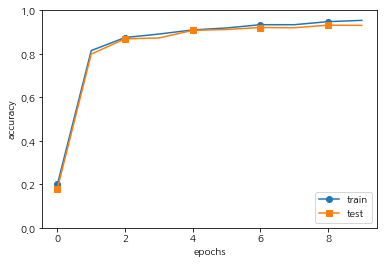

In [10]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
